In [1]:
import ee
import geemap
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#Create Map and center on Manauas EC Flux Tower coordinates
Map = geemap.Map(center = (-2.609097222, -60.20929722), zoom = 10)
brma2_point = ee.Geometry.Point(-60.20929722, -2.609097222)
brma2_region = ee.Geometry.Rectangle(-60.50, -2.85, -60.00, -2.35)
Map

In [10]:
#Calculate NDRE and set palette
def addNDRE(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)
ndre_params = ({'min': 0.0,'max': 1.0, 'palette' : 
               ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']})

In [11]:
#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int()
cirrusBitMask = ee.Number(2).pow(11).int()
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [12]:
#Load sentinel-2 data and clip to brma_2; set visual params
s2 = (ee.ImageCollection('COPERNICUS/S2') #Select S2 1-C level data
     .filterBounds(brma2_region) #Grab tiles that intersect Manaus, BR, region
     .filterDate('2016-01-01', '2016-12-31') #Select year I want
     .map(addNDRE)) #Select bands I want

In [13]:
#Create a masked collection
masked = s2.map(maskS2clouds)

In [87]:
#Find median NDRE of each month in 2016 and save to image collection
months = ee.List.sequence(1, 12) #Create a list with nums 1-12

def byMonth (m):
    month = (masked.filter(ee.Filter.calendarRange(m, m, 'month')) #(start, end, field)
             .median() #Calculate median for all bands I selected
             .set('month', m)) #Make month a property
    return month

masked_collection = ee.ImageCollection.fromImages(months.map(byMonth))
masked_collection = masked_collection.map(lambda image: image.clip(brma2_region))

In [90]:
#Select one image from the collection
july = masked_collection.filterMetadata('month', 'equals', 7) #1 is January, 12 is December
july = july.select('NDRE').median() #Have to do this for below to work

In [98]:
#Dr. Wu's ee_to_numpy function re-written:
bands = july.bandNames().getInfo()
print(str('band names: ') + str(bands))

band_arrs = july.sampleRectangle(region=brma2_point) #2-D pixel array as property per band
band_values = [] #Create empty array
for band in bands:
    band_arr = band_arrs.get(band).getInfo() #Get property values for each band
    band_value = np.array(band_arr) #Create numpy array
    band_values.append(band_value) #Fill empty array
    
values = np.dstack(band_values) #Create variable for filled array
values = image.flatten() #Turn 3D array into 1D array
print(str('band values: ') + str(values)) #Print the filled array

band names: ['NDRE']
band values: [0.52534008]


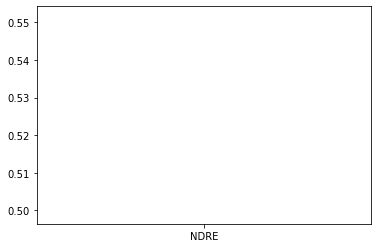

In [99]:
x = bands
y = values
plt.plot(x,y) 
plt.show()